In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
from tqdm import tqdm

import tensorflow as tf
# from tensorflow.keras.datasets import cifar10
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
# from tensorflow.keras.layers import Conv2D, MaxPooling2D

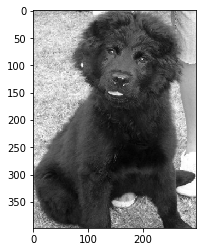

In [2]:
DATADIR = "./pet_images/PetImages"

CATEGORIES = ["Dog", "Cat"]

for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        plt.imshow(img_array, cmap='gray')  # graph it
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [3]:
print(img_array)

[[179 193 196 ... 215 221 223]
 [198 203 189 ... 214 223 225]
 [182 188 182 ... 222 221 224]
 ...
 [209 209 209 ... 187 170 147]
 [199 207 210 ... 198 174 144]
 [198 206 209 ... 205 195 150]]


In [4]:
print(img_array.shape)  # wymiary zdjecia

(398, 298)


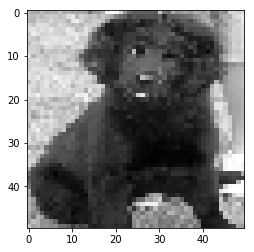

In [5]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # przeskalowanie 398x298 -> 50x50
plt.imshow(new_array, cmap='gray')
plt.show()

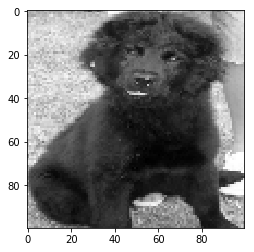

In [6]:
IMG_SIZE = 100

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # przeskalowanie 398x298 -> 100x100
plt.imshow(new_array, cmap='gray')
plt.show()

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))  # 25k zdjec, powinno byc tyle samo psow i tyle samo kotow, 
# jezeli nie to wycinamy iles zdjec z wiekszego zbioru

100%|██████████| 12501/12501 [00:12<00:00, 994.06it/s] 

24946


In [8]:
# pomieszamy zdjecia, zeby bylo latwo podzielic
random.shuffle(training_data)
# Our training_data is a list, meaning it's mutable, so it's now nicely shuffled. 
# We can confirm this by iterating over a few of the initial samples and printing out the class.

for sample in training_data[:10]:
    print(sample[1])

0
0
1
1
1
0
1
0
1
1


In [9]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[131]
   [100]
   [ 93]
   ...
   [102]
   [106]
   [101]]

  [[112]
   [ 95]
   [ 97]
   ...
   [ 93]
   [ 97]
   [108]]

  [[103]
   [ 95]
   [ 92]
   ...
   [ 96]
   [ 94]
   [106]]

  ...

  [[219]
   [172]
   [179]
   ...
   [233]
   [229]
   [230]]

  [[166]
   [102]
   [228]
   ...
   [227]
   [223]
   [237]]

  [[157]
   [175]
   [110]
   ...
   [229]
   [222]
   [232]]]]


In [10]:
pickle_out = open("pet_images/X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("pet_images/y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [3]:
pickle_in = open("pet_images/X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("pet_images/y.pickle","rb")
y = pickle.load(pickle_in)

# Tworzenie modelu

In [4]:
X = X/255.0  # normalizacja

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(256, (3, 3), input_shape=X.shape[1:]))  # 256 kanalow, z filtrem 3x3
model.add(tf.keras.layers.Activation('relu'))  # czyli 100x100x1 -> 98x98x256
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))  # pooling 2x2, czyli 98x98x256 -> 49x49x256

model.add(tf.keras.layers.Conv2D(256, (3, 3)))  # 49x49x256 -> 47x47x256
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))  # 47x47x256 -> 23x23x256

model.add(tf.keras.layers.Flatten())  # 23x23x256 -> 1x135424x1 this converts our 3D feature maps to 1D feature vectors

model.add(tf.keras.layers.Dense(64))  # 1x135424x1 -> 1x64x1

model.add(tf.keras.layers.Dense(1))  # 1x64x1 -> 1x1x1
model.add(tf.keras.layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X, y, batch_size=96, epochs=1, validation_split=0.3)

Train on 17462 samples, validate on 7484 samples
Epoch 1/1
17462/17462 [==============================] - 2567s 147ms/step - loss: 0.7069 - acc: 0.6093 - val_loss: 0.6334 - val_acc: 0.6494


# Tensorboard

In [5]:
NAME = "Cats-vs-dogs-CNN"

tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME))

In [6]:
model.fit(X, y,
          batch_size=96,
          epochs=1,
          validation_split=0.3,
          callbacks=[tensorboard])

Train on 17462 samples, validate on 7484 samples
Epoch 1/1
17462/17462 [==============================] - 2492s 143ms/step - loss: 0.5991 - acc: 0.6790 - val_loss: 0.5637 - val_acc: 0.7115


t
